In [23]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

In [24]:
# Load dataset
df = pd.read_csv("audio_features_for_all_songs.csv")
df = df.head(1000)

df.shape

(1000, 23)

In [25]:
# Select audio features for clustering
audio_features = [
    "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo", "time_signature"
]

# Clean data (drop the 27 missing values)
df = df.dropna(subset=audio_features)
df.shape

(1000, 23)

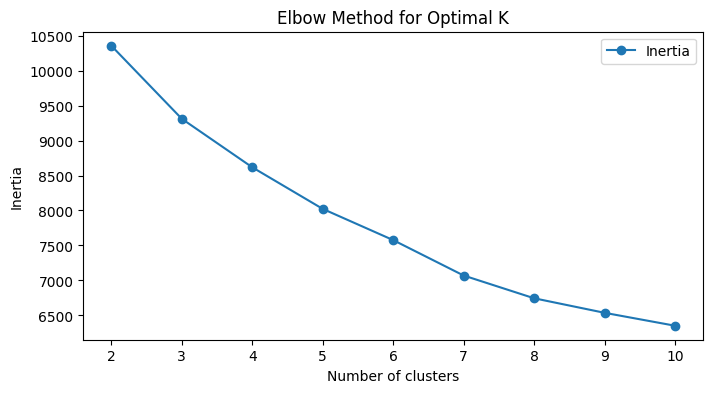

In [26]:
# Normalise features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[audio_features]), columns=audio_features)

# Find optimal number of clusters using Elbow Method
inertia = []
sil_scores = []
K_range = range(2, 11) # Test cluster size from 2 - 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker="o", linestyle="-", label="Inertia")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.show()

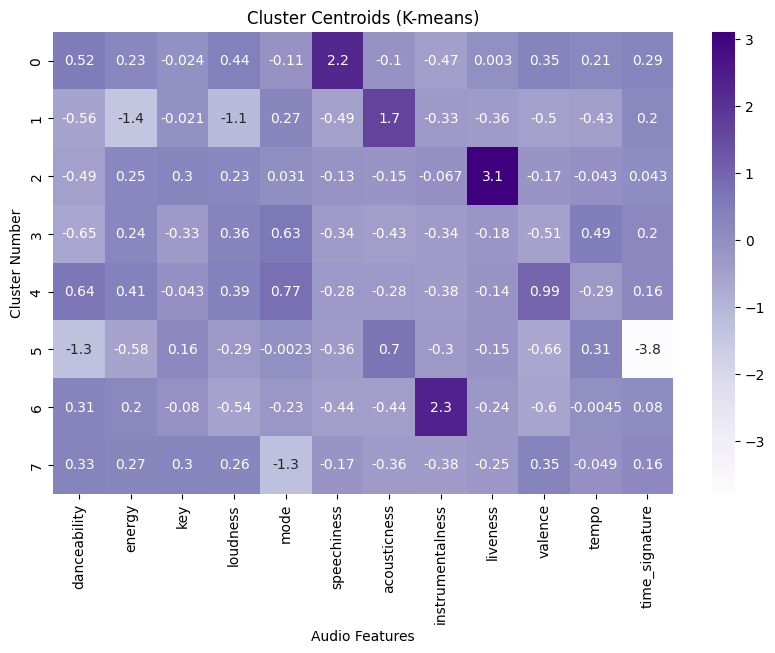

In [27]:
optimal_k = 8

# K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(df_scaled)

# Analyse cluster centroids
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=audio_features)

# Heatmap of cluster centroids
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centers, cmap="Purples", annot=True)
plt.title("Cluster Centroids (K-means)")
plt.xlabel("Audio Features")
plt.ylabel("Cluster Number")
plt.show()

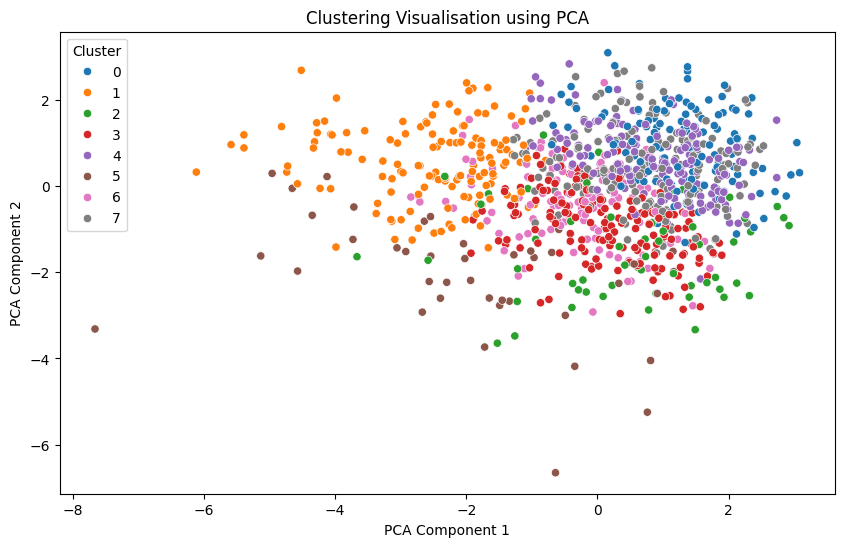

In [28]:
# PCA to reduce dimensionality for visualisation
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df["PCA1"] = df_pca[:, 0]
df["PCA2"] = df_pca[:, 1]

# Visualise clusters in 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["PCA1"], y=df["PCA2"], hue=df["cluster"], palette="tab10")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustering Visualisation using PCA")
plt.legend(title="Cluster")
plt.show()

In [29]:
# Assign Genre Scores (Soft clustering)
distances = cdist(df_scaled, kmeans.cluster_centers_, metric="euclidean")
genre_scores = np.exp(-distances) # Convert distances to similarity scores
genre_scores = genre_scores / genre_scores.sum(axis=1, keepdims=True) # Normalise scores

# Store genre scores
genre_scores_df = pd.DataFrame(genre_scores, columns=[f"Genre {i}" for i in range(optimal_k)])
df = pd.concat([df, genre_scores_df], axis=1)

"""
Key Observations from Heatmap:
Cluster 0: High instrumentalness (2.2), relatively neutral other features → Likely Instrumental Music / Ambient Sounds.
Cluster 1: Low energy (-1.4), low loudness (-1.1), slightly high acousticness (1.7) → Likely Soft Acoustic / Classical.
Cluster 2: High instrumentalness (3.1), slight positive in key and loudness → Likely Orchestral / Soundtrack.
Cluster 3: Moderate mode (0.63), moderate danceability (0.24) → Likely Mid-tempo Pop / Indie.
Cluster 4: High mode (0.77), moderate danceability & energy → Likely Upbeat Electronic / Dance.
Cluster 5: Very low danceability (-1.3), low energy (-0.58), low tempo (-3.8) → Likely Slow & Melancholic (Sad Songs).
Cluster 6: High instrumentalness (2.3), moderate mode (-0.44) → Likely Experimental / Jazz Fusion.
Cluster 7: Low loudness (-1.3), balanced tempo and valence → Likely Lo-Fi / Chill Vibes.
"""

# Assign descriptive labels to each cluster
descriptive_labels = [
    "Instrumental / Ambient Sounds", # Cluster 0
    "Soft Acoustic / Classical", # Cluster 1
    "Orchestral / Soundtrack", # Cluster 2
    "Mid-tempo Pop / Indie", # Cluster 3
    "Upbeat Electronic / Dance", # Cluster 4
    "Slow & Mlancholic (Sad Songs)", # Cluster 5
    "Experimental / Jaz Fusion", # Cluster 6
    "Lo-Fi / Chill Vibes" # Cluster 7
]

df["Cluster Label"] = df["cluster"].map(lambda x: descriptive_labels[x])
df.to_csv("100_songs_processed_music_dataset.csv", index=False)

df.head()

,Unnamed: 0,track_uri,album_name,album_uri,artist_name,artist_uri,duration_ms,pos,track_name,inside_playlists,...,PCA2,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Cluster Label
0,0,spotify:track:2sywvGUBuSuYICHHKOElSn,Knock Madness,spotify:album:16SMGvTZrwtiJ132g69toP,Hopsin,spotify:artist:7EWU4FhUJM1sZQgQKdENeT,211573,106,Nollie Tre Flip,[490052 555653 238949 903979],...,1.570390,0.440356,0.048576,0.028006,0.096253,0.209706,0.011468,0.049970,0.115665,Instrumental / Ambient Sounds
1,1,spotify:track:7n1y18wPhZv5YxpR6nFBck,Knock Madness,spotify:album:16SMGvTZrwtiJ132g69toP,Hopsin,spotify:artist:7EWU4FhUJM1sZQgQKdENeT,257600,107,I Need Help,[490052 39023 555653 824939 773078 883606 134...,...,0.280382,0.111097,0.043384,0.032143,0.162857,0.116535,0.014941,0.069169,0.449874,Lo-Fi / Chill Vibes
2,2,spotify:track:1zZXXOfcYKJbUh494VmGVB,Knock Madness,spotify:album:16SMGvTZrwtiJ132g69toP,Hopsin,spotify:artist:7EWU4FhUJM1sZQgQKdENeT,231493,108,Rip Your Heart Out (feat. Tech N9ne),[490052 824939 148259 288353 80500 883606 717...,...,0.485226,0.373902,0.059271,0.086100,0.113114,0.096009,0.021053,0.067467,0.183083,Instrumental / Ambient Sounds
3,3,spotify:track:4lDRCZho3GlmRqOJRjmLfE,Bout the Business,spotify:album:6kVdsufIniV3hlXSxKxax2,Hopsin,spotify:artist:7EWU4FhUJM1sZQgQKdENeT,272360,110,Bout the Business,[490052 39023 220264 990366 953564 642810 615...,...,0.135228,0.330934,0.052703,0.041709,0.213650,0.141223,0.018594,0.069857,0.131330,Instrumental / Ambient Sounds
4,4,spotify:track:5wWDfRF7NQKMx8ZPfrhBwa,Funk Volume 2013 - Single,spotify:album:6pCCQ7R7J4N2femfQVbFg2,Hopsin,spotify:artist:7EWU4FhUJM1sZQgQKdENeT,313195,112,Funk Volume 2013,[490052 288353 857174],...,0.883616,0.317926,0.046268,0.034238,0.152307,0.210666,0.014348,0.074007,0.150241,Instrumental / Ambient Sounds


In [30]:
# Show the number of songs per cluster
print("Songs per Cluster:")
print(df["Cluster Label"].value_counts())

Songs per Cluster:
Cluster Label
Lo-Fi / Chill Vibes              174
Upbeat Electronic / Dance        166
Mid-tempo Pop / Indie            164
Soft Acoustic / Classical        138
Experimental / Jaz Fusion        131
Instrumental / Ambient Sounds    125
Orchestral / Soundtrack           59
Slow & Mlancholic (Sad Songs)     43
Name: count, dtype: int64
